# Feature Extraction

In [1]:
import os
import random
import numpy as np
import skimage as ski

# Path to the Train and Test folders
train_folder = 'data/Train'


# Dictionary to store HOG features for each class
hog_features = dict()

# Go through each class folder in the Train directory
for class_folder in os.listdir(train_folder):
    class_path = os.path.join(train_folder, class_folder)

    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path) if f.endswith('.png')]
        selected_images = random.sample(image_files, min(100, len(image_files)))

        class_hog_features = list()

        for image_file in selected_images:
            image_path = os.path.join(class_path, image_file)

            image = ski.io.imread(image_path, as_gray=True)
            resized_image = ski.transform.resize(image, (32,32), anti_aliasing=True)

            hog_feature = ski.feature.hog(resized_image)

            class_hog_features.append(hog_feature)

            hog_features[class_folder] = class_hog_features

# Model Training

In [2]:
import pandas as pd

training_set = pd.DataFrame()

for label in hog_features.keys():
    class_df = pd.DataFrame(hog_features[label])
    class_df['label'] = int(label)
    training_set = pd.concat([training_set, class_df], axis='index', ignore_index=True)

training_set.shape

(4300, 325)

To show the concept, we will use a SVM as our classifier

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics

X = training_set.iloc[:,0:-1].copy()
Y = training_set.iloc[:,-1]

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train a classifier based on the collected data and use grid search for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(svm.SVC(), param_grid, cv=5)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf']})

# Model Evaluation

In [4]:
svm_classifier = grid_search.best_estimator_

Y_pred = svm_classifier.predict(X_val)

# Compute performance metrics
accuracy = metrics.accuracy_score(Y_val, Y_pred)
classification_report = metrics.classification_report(Y_val, Y_pred)

print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 0.9093023255813953


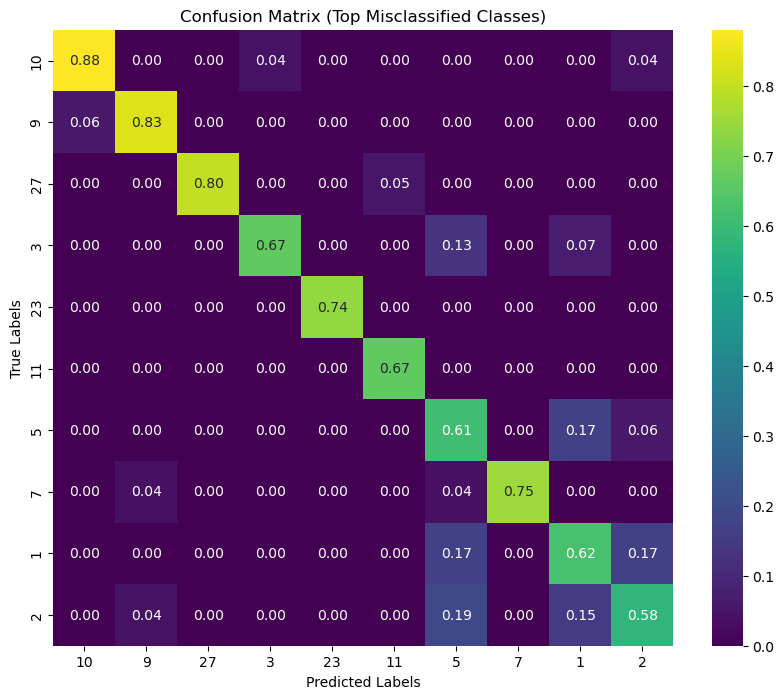

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = metrics.confusion_matrix(Y_val, Y_pred)

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

misclassification_rates = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)
top_misclassified_indices = np.argsort(misclassification_rates)[-10:]

filtered_conf_matrix = conf_matrix_normalized[np.ix_(top_misclassified_indices, top_misclassified_indices)]
filtered_labels = [svm_classifier.classes_[i] for i in top_misclassified_indices]

plt.figure(figsize=(10, 8))
sns.heatmap(filtered_conf_matrix, annot=True, fmt=".2f", xticklabels=filtered_labels, yticklabels=filtered_labels, cmap='viridis')
plt.title("Confusion Matrix (Top Misclassified Classes)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()